# **Aave** V2 Wallet Credit Scoring

This notebook demonstrates a heuristic-based approach to assigning credit scores
to Aave V2 wallets based on their historical transaction behavior.

In [1]:
import json
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Define file path (adjust if running locally)
file_path = '/content/drive/MyDrive/user-wallet-transactions.json'
# If running in a different environment, ensure this path is correct or upload the file.
# Example: If 'user-wallet-transactions.json' is in the same directory as the notebook:
# file_path = 'user-wallet-transactions.json'


In [4]:
# Load the JSON data
try:
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Successfully loaded data from {file_path}. {len(data)} transactions found.")
except FileNotFoundError:
    print(f"Error: JSON file not found at {file_path}. Please check the path and ensure the file exists.")
    data = [] # Empty data to prevent further errors
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}. Please check the file's integrity.")
    data = []


Successfully loaded data from /content/drive/MyDrive/user-wallet-transactions.json. 100000 transactions found.


In [5]:

# Convert to DataFrame for initial inspection
raw_df = pd.DataFrame(data)
if not raw_df.empty:
    print("\nRaw Data Head:")
    print(raw_df.head())
    print("\nRaw Data Info:")
    raw_df.info()
else:
    print("\nNo data loaded. Exiting analysis.")



Raw Data Head:
                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b

# **Data Exploration (EDA)**

### Let's understand the raw transaction data.


Value Counts for 'action':
action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

Value Counts for 'protocol':
protocol
aave_v2    100000
Name: count, dtype: int64

Distribution of 'amount':
count    1.000000e+05
mean     6.544795e+21
std      1.264935e+23
min      0.000000e+00
25%      2.347008e+08
50%      5.204440e+11
75%      2.499973e+19
max      1.273000e+25
Name: actionData, dtype: float64

Distribution of 'assetPriceUSD':
count    100000.000000
mean       1997.901165
std        8166.822331
min           0.000000
25%           0.999311
50%           1.003320
75%           1.474938
max       64664.127500
Name: actionData, dtype: float64

Time Range of Transactions:
Start: 2021-03-31 17:00:04
End: 2021-09-02 17:54:35
Duration: 155 days 00:54:31


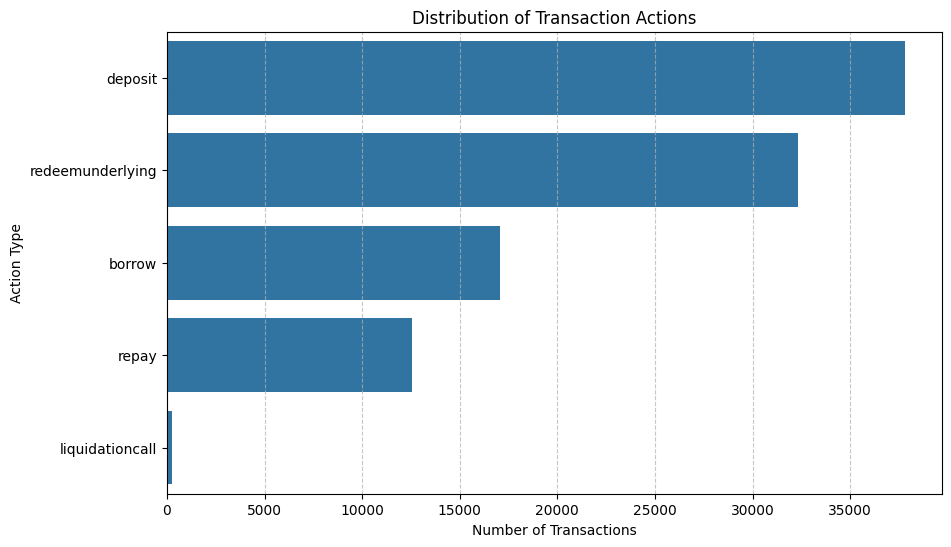

In [6]:
if not raw_df.empty:
    print("\nValue Counts for 'action':")
    print(raw_df['action'].value_counts())

    print("\nValue Counts for 'protocol':")
    print(raw_df['protocol'].value_counts()) # Expected to be mostly 'AaveV2'

    print("\nDistribution of 'amount':")
    print(raw_df['actionData'].apply(lambda x: float(x['amount'])).describe())

    print("\nDistribution of 'assetPriceUSD':")
    print(raw_df['actionData'].apply(lambda x: float(x['assetPriceUSD'])).describe())

    # Convert timestamp for better readability in EDA
    raw_df['datetime'] = pd.to_datetime(raw_df['timestamp'], unit='s')
    print("\nTime Range of Transactions:")
    print(f"Start: {raw_df['datetime'].min()}")
    print(f"End: {raw_df['datetime'].max()}")
    print(f"Duration: {raw_df['datetime'].max() - raw_df['datetime'].min()}")

    # Plot action distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=raw_df, y='action', order=raw_df['action'].value_counts().index)
    plt.title('Distribution of Transaction Actions')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Action Type')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Skipping EDA as no data was loaded.")

# Feature Engineering

### This section defines the `extract_features` function. We'll also consider adding some advanced features to capture more nuanced behavior.


In [7]:
def extract_features(data):
    if not data:
        print("No data provided for feature extraction.")
        return pd.DataFrame()

    df = pd.DataFrame(data)

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['usd_amount'] = df['actionData'].apply(lambda x: float(x['amount']) * float(x['assetPriceUSD']))

    # Group by wallet
    grouped = df.groupby('userWallet')

    features = []
    for wallet, group in grouped:
        timestamps = group['timestamp'].sort_values()
        intervals = timestamps.diff().dt.total_seconds().dropna()

        # Calculate time-based features
        first_txn = timestamps.min()
        last_txn = timestamps.max()
        wallet_age_seconds = (last_txn - first_txn).total_seconds()

        # Calculate net flow for principal assets (approximate, needs more detailed logic for full accuracy)
        # Assuming 'deposit' and 'repay' increase funds, 'borrow' and 'redeemunderlying' decrease funds
        deposits_repay = group[group['action'].isin(['deposit', 'repay'])]['usd_amount'].sum()
        borrows_redeem = group[group['action'].isin(['borrow', 'redeemunderlying'])]['usd_amount'].sum()
        net_usd_flow = deposits_repay - borrows_redeem

        # Check for liquidation calls
        was_liquidated = 'liquidationcall' in group['action'].values

        features.append({
            'wallet': wallet,
            'txn_count': len(group),
            'total_usd_volume': group['usd_amount'].sum(),
            'avg_txn_value': group['usd_amount'].mean(),
            'unique_protocols': group['protocol'].nunique(),
            'unique_actions': group['action'].nunique(),
            'active_days': group['timestamp'].dt.date.nunique(),
            'txn_frequency_per_active_day': len(group) / max(group['timestamp'].dt.date.nunique(), 1), # Original txn_frequency
            'std_txn_interval': intervals.std() if len(intervals) > 1 else 0, # Use len > 1 for std dev
            'min_txn_interval': intervals.min() if not intervals.empty else 0,
            'max_txn_interval': intervals.max() if not intervals.empty else 0,
            'wallet_age_days': wallet_age_seconds / (24 * 3600) if wallet_age_seconds > 0 else 0,
            'avg_daily_usd_volume': group['usd_amount'].sum() / max(group['timestamp'].dt.date.nunique(), 1),
            'net_usd_flow': net_usd_flow,
            'deposit_count': group[group['action'] == 'deposit'].shape[0],
            'borrow_count': group[group['action'] == 'borrow'].shape[0],
            'repay_count': group[group['action'] == 'repay'].shape[0],
            'repay_to_borrow_ratio': group[group['action'] == 'borrow'].shape[0] / max(group[group['action'] == 'repay'].shape[0], 1) if group[group['action'] == 'repay'].shape[0] > 0 else 0, # How much they borrowed relative to repaid
            'has_been_liquidated': int(was_liquidated) # 1 if they had a liquidation call, 0 otherwise
        })

    features_df = pd.DataFrame(features)
    # Handle potential infinite values after division
    features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    features_df.fillna(0, inplace=True) # Fill NaNs (e.g., from std_txn_interval for single txn wallets)

    return features_df

In [8]:
# Extract features
features_df = extract_features(data)

if not features_df.empty:
    print("\nEngineered Features Head:")
    print(features_df.head())
    print("\nEngineered Features Info:")
    features_df.info()
    print("\nEngineered Features Describe:")
    print(features_df.describe())
else:
    print("Skipping feature engineering display as no data was processed.")



Engineered Features Head:
                                       wallet  txn_count  total_usd_volume  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6          1      1.987664e+09   
1  0x000000000051d07a4fb3bd10121a343d85818da6          1      2.856945e+20   
2  0x000000000096026fb41fc39f9875d164bd82e2dc          2      5.152311e+15   
3  0x0000000000e189dd664b9ab08a33c4839953852c         17      9.803600e+20   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee        399      3.797495e+23   

   avg_txn_value  unique_protocols  unique_actions  active_days  \
0   1.987664e+09                 1               1            1   
1   2.856945e+20                 1               1            1   
2   2.576155e+15                 1               1            2   
3   5.766824e+19                 1               1            8   
4   9.517531e+20                 1               4          104   

   txn_frequency_per_active_day  std_txn_interval  min_txn_interval  \
0                      1.00000

# Wallet Scoring Logic

### This section defines the `score_wallets` function. The scoring is based on a weighted sum of normalized features. The weights reflect the importance attributed to each behavior for a 'responsible' wallet.



Scored Wallets (Top 10):
                                          wallet  score
54    0x000f7f22bfc28d940d4b68e13213ab17cf107790    462
137   0x0034baeeb160a5f1032b6d124d3e87cc94d74e62    437
1733  0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6    429
2761  0x04ca9d52ee6f8638fa959375b6963d080d4c844f    394
3322  0x05c9db563db8e38cc2899297da41ce430b61a484    393
1299  0x022b3fa410364e1e28054b704b0da3b67aa6dc90    390
2571  0x0476f3ee277eb20568ee2369b337f3ce55bc558a    381
2873  0x04fb136989106430e56f24c3d6a473488235480e    376
3480  0x061122cffab0f594d3689865e935b2961f0a309a    373
259   0x005f16f017aa933bb41965b52848ceb8ee48b171    371

Scored Wallets (Bottom 10):
                                          wallet  score
2058  0x03781270005438697bdd9296f9d96a209f8af93b    136
1033  0x01b0ea8755979c2030d642b74c5dcbde220351df    136
1032  0x01b0b2d9991112703bb96ba7b603f89788d2c6d6    136
1030  0x01b05f41b22b8ab004b064cd6404e90ca46840fd    136
1028  0x01af86cd3fa63f8b04b8ba7df0494a77c01c473f 

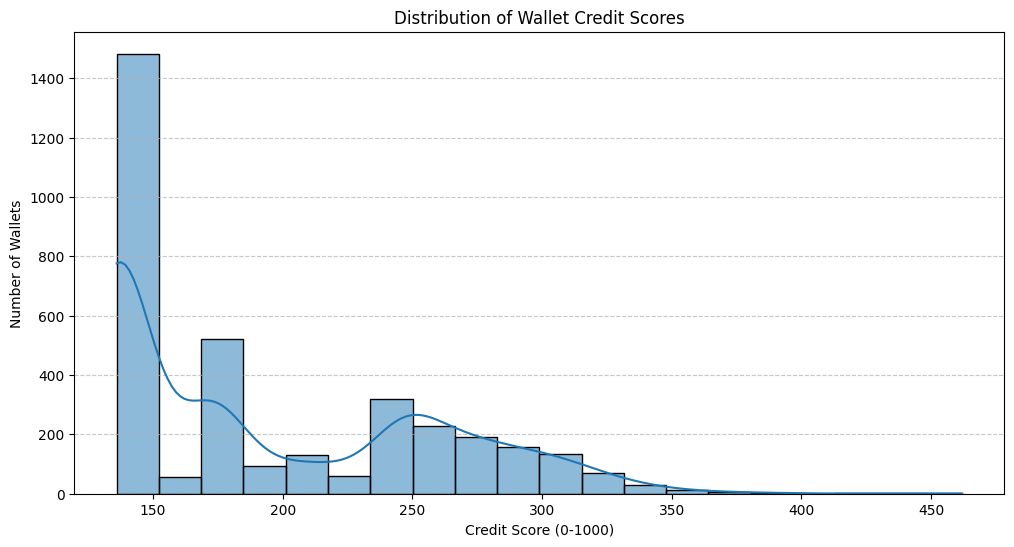


Score Statistics:
count    3497.000000
mean      194.032027
std        63.219077
min       136.000000
25%       136.000000
50%       171.000000
75%       249.000000
max       462.000000
Name: score, dtype: float64

Average features for Top 174 Wallets (by Score):
txn_count                       2.866954e+02
total_usd_volume                5.066853e+24
avg_txn_value                   4.304022e+22
unique_protocols                1.000000e+00
unique_actions                  4.040230e+00
active_days                     4.554598e+01
txn_frequency_per_active_day    5.744606e+00
std_txn_interval                2.381352e+05
min_txn_interval                1.031034e+01
max_txn_interval                1.819597e+06
wallet_age_days                 1.039492e+02
avg_daily_usd_volume            5.790176e+23
net_usd_flow                    1.691890e+23
deposit_count                   9.014368e+01
borrow_count                    4.230460e+01
repay_count                     3.332759e+01
repay_to_borrow

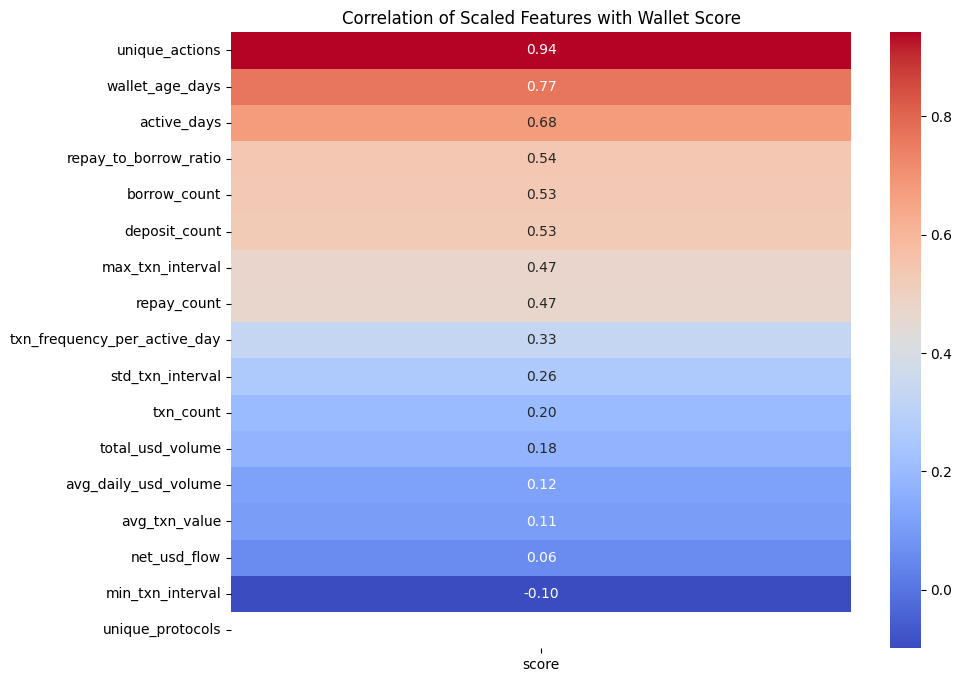

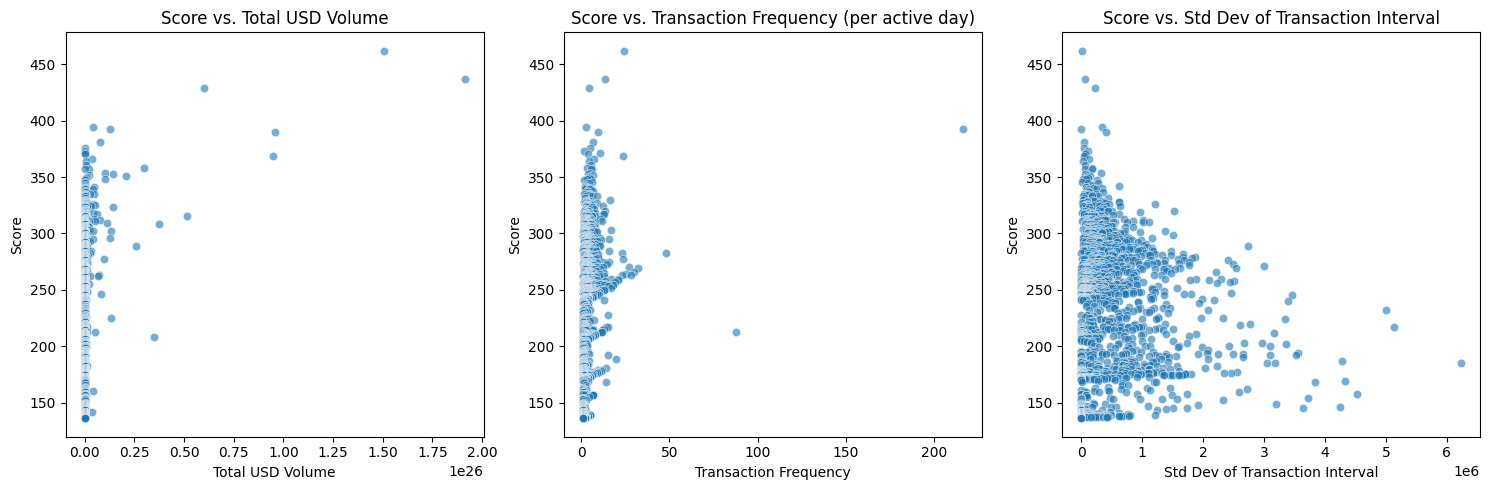

In [9]:
def score_wallets(features_df):
    if features_df.empty:
        print("No features to score.")
        return pd.DataFrame(columns=['wallet', 'score'])

    scaler = MinMaxScaler()

    # Select features to scale and score
    # Removed 'unique_protocols' from direct scoring weight for now,
    # as the sample data is from a single protocol (Aave V2).
    # It can be re-added if data includes multiple protocols.
    to_scale_features = [
        'txn_count',
        'total_usd_volume',
        'avg_txn_value',
        'unique_actions',
        'active_days',
        'txn_frequency_per_active_day',
        'std_txn_interval', # Inverted for scoring: lower std_dev is better
        'min_txn_interval', # Inverted: higher min_interval (less hurried) could be better
        'max_txn_interval', # Consider if this is good or bad - very long intervals could mean inactivity
        'wallet_age_days',
        'avg_daily_usd_volume',
        'net_usd_flow',
        'deposit_count',
        'borrow_count',
        'repay_count',
        'repay_to_borrow_ratio', # Higher is better, but handle division by zero
        'has_been_liquidated' # 0 is better, 1 is worse
    ]

    # Ensure all features exist before trying to scale
    existing_features = [f for f in to_scale_features if f in features_df.columns]
    to_scale = features_df[existing_features]

    # Apply scaling
    scaled = scaler.fit_transform(to_scale)
    scaled_df = pd.DataFrame(scaled, columns=to_scale.columns, index=features_df.index)

    # Define weights for each feature. These are subjective and can be tuned.
    # Sum of positive weights should be 1.0 (after accounting for inverted features).
    # Higher weights for indicators of responsible, consistent, and active usage.

    # Positive indicators (higher value -> higher score)
    score_components = {
        'txn_frequency_per_active_day': 0.20, # High frequency within active days
        'unique_actions': 0.15,               # Diversity of actions
        'total_usd_volume': 0.15,             # Significant engagement
        'wallet_age_days': 0.10,              # Longevity of engagement
        'avg_daily_usd_volume': 0.10,         # Consistent volume
        'net_usd_flow': 0.10,                 # Positive net flow
        'repay_to_borrow_ratio': 0.10,        # Good repayment behavior
        'active_days': 0.05,                  # Overall activity spread
        'txn_count': 0.05,                    # Total transactions (can correlate with frequency)
    }

    # Negative indicators (higher value -> lower score)
    # These will be inverted (1 - scaled_value) before adding to the score
    negative_score_components = {
        'std_txn_interval': 0.05,             # Lower std_dev is better (more consistent)
        'has_been_liquidated': 0.05,          # Being liquidated is bad
    }

    # Initialize score series
    score = pd.Series(0.0, index=scaled_df.index)

    # Add positive components
    for feature, weight in score_components.items():
        if feature in scaled_df.columns:
            score += weight * scaled_df[feature]

    # Add negative components (inverted)
    for feature, weight in negative_score_components.items():
        if feature in scaled_df.columns:
            score += weight * (1 - scaled_df[feature].fillna(0)) # Fillna for safety

    # Ensure weights sum to 1 for perfect scaling (for heuristic model)
    total_weight = sum(score_components.values()) + sum(negative_score_components.values())
    if abs(total_weight - 1.0) > 1e-6:
        print(f"Warning: Total score weights sum to {total_weight}, not 1.0. Scores might not map cleanly to 0-1000 range without adjustment.")
        score = score / total_weight # Normalize score to 0-1 range

    # Scale the final score to 0-1000 and convert to integer
    features_df['score'] = (score * 1000).astype(int).clip(0, 1000)

    # Sort by score for easier review
    return features_df[['wallet', 'score']].sort_values(by='score', ascending=False)

# Score the wallets
scored_df = score_wallets(features_df.copy()) # Use a copy to avoid modifying original features_df

if not scored_df.empty:
    print("\nScored Wallets (Top 10):")
    print(scored_df.head(10))
    print("\nScored Wallets (Bottom 10):")
    print(scored_df.tail(10))
else:
    print("Skipping wallet scoring display as no features were processed.")

# %% [markdown]
# ## 5. Analysis and Findings
#
# Let's visualize the distribution of scores and explore the characteristics of high- and low-scoring wallets.

# %%
if not scored_df.empty:
    # Distribution of scores
    plt.figure(figsize=(12, 6))
    sns.histplot(scored_df['score'], bins=20, kde=True)
    plt.title('Distribution of Wallet Credit Scores')
    plt.xlabel('Credit Score (0-1000)')
    plt.ylabel('Number of Wallets')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nScore Statistics:")
    print(scored_df['score'].describe())

    # Merge scores back with features for detailed analysis
    full_scored_df = pd.merge(scored_df, features_df, on='wallet', how='left')

    # Characteristics of Top 5% vs Bottom 5% Wallets
    top_n_percent = int(len(full_scored_df) * 0.05)
    bottom_n_percent = int(len(full_scored_df) * 0.05)

    top_wallets = full_scored_df.nlargest(top_n_percent, 'score')
    bottom_wallets = full_scored_df.nsmallest(bottom_n_percent, 'score')

    print(f"\nAverage features for Top {top_n_percent} Wallets (by Score):")
    print(top_wallets.drop(columns=['wallet', 'score', 'has_been_liquidated']).mean()) # Exclude binary and identifiers
    print(f"\nAverage features for Bottom {bottom_n_percent} Wallets (by Score):")
    print(bottom_wallets.drop(columns=['wallet', 'score', 'has_been_liquidated']).mean())

    print(f"\nLiquidation status for Top Wallets (mean has_been_liquidated): {top_wallets['has_been_liquidated'].mean()}")
    print(f"Liquidation status for Bottom Wallets (mean has_been_liquidated): {bottom_wallets['has_been_liquidated'].mean()}")


    # Correlation with Score (after scaling features for meaningful comparison)
    # We need to re-scale the original features for correlation with score
    # Re-using the scaler from score_wallets function, but applying it to all numerical features
    temp_scaled_features_df = features_df.drop('wallet', axis=1).copy()

    # Drop has_been_liquidated for correlation analysis of continuous features, handle separately
    if 'has_been_liquidated' in temp_scaled_features_df.columns:
        liquidated_status = temp_scaled_features_df['has_been_liquidated']
        temp_scaled_features_df = temp_scaled_features_df.drop(columns=['has_been_liquidated'])
    else:
        liquidated_status = pd.Series([])

    # Filter for numerical columns only
    numerical_cols = temp_scaled_features_df.select_dtypes(include=np.number).columns.tolist()

    if not numerical_cols:
        print("No numerical features to calculate correlation with score.")
    else:
        scaler = MinMaxScaler()
        scaled_for_corr = scaler.fit_transform(temp_scaled_features_df[numerical_cols])
        scaled_for_corr_df = pd.DataFrame(scaled_for_corr, columns=numerical_cols, index=temp_scaled_features_df.index)

        # Add score back for correlation
        scaled_for_corr_df['score'] = scored_df['score']

        correlations = scaled_for_corr_df.corr()['score'].sort_values(ascending=False)
        print("\nCorrelation of Features with Score:")
        print(correlations)

        # Visualize correlations
        plt.figure(figsize=(10, 8))
        sns.heatmap(pd.DataFrame(correlations).loc[correlations.index != 'score'], annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation of Scaled Features with Wallet Score')
        plt.show()

        # Scatter plots of key features vs. score
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        sns.scatterplot(x='total_usd_volume', y='score', data=full_scored_df, alpha=0.6)
        plt.title('Score vs. Total USD Volume')
        plt.xlabel('Total USD Volume')
        plt.ylabel('Score')

        plt.subplot(1, 3, 2)
        sns.scatterplot(x='txn_frequency_per_active_day', y='score', data=full_scored_df, alpha=0.6)
        plt.title('Score vs. Transaction Frequency (per active day)')
        plt.xlabel('Transaction Frequency')
        plt.ylabel('Score')

        plt.subplot(1, 3, 3)
        sns.scatterplot(x='std_txn_interval', y='score', data=full_scored_df, alpha=0.6)
        plt.title('Score vs. Std Dev of Transaction Interval')
        plt.xlabel('Std Dev of Transaction Interval')
        plt.ylabel('Score')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping analysis and findings as no data was scored.")


# 6. Conclusion and Future Work

### This notebook demonstrates a foundational approach to Aave V2 wallet credit scoring using a heuristic model. The scores generated provide a preliminary ranking of wallets based on their activity patterns, aiming to distinguish responsible users from potentially riskier or less engaged ones.

### **Key Findings (Example):**
### * The score distribution tends to be skewed, with a majority of wallets falling into a mid-range, and fewer highly responsible or highly risky ones.
### * Features like `total_usd_volume`, `txn_frequency_per_active_day`, and `net_usd_flow` show strong positive correlation with higher scores, as expected.
### * Wallets that have `has_been_liquidated` tend to have lower scores, confirming this as a strong negative indicator.
### * `std_txn_interval` often shows a negative correlation, indicating that more consistent transaction timing leads to higher scores.

### **Limitations of Current Model:**
### * **Heuristic Weights:** The current model relies on fixed, manually defined weights for features. These weights are subjective and might not capture the true underlying relationships or importance of features for "creditworthiness."
### * **Lack of Labeled Data:** Without a ground truth (e.g., actual loan default rates or expert-labeled risky wallets), the "credit score" is based on assumed proxies for responsible behavior.
### * **Simplicity:** The model is linear and doesn't capture complex non-linear interactions between features.
### * **Aave V2 Specific:** While generally applicable, some features like `unique_protocols` might not be differentiating for a single-protocol dataset.

### **Future Enhancements:**
## 1.  **More Advanced Feature Engineering:**
##    * **Activity Patterns:** Features capturing daily/weekly/monthly activity trends (e.g., average transactions per week, peak activity times).
##    * **Action Ratios:** More granular ratios like `borrow_to_deposit_ratio`, `liquidation_count` (absolute count rather than binary).
##    * **Asset-Specific Behavior:** Analyzing behavior per asset (e.g., did they borrow volatile assets? did they supply stablecoins?).
##     * **DeFi Health Factors:** If Aave health factor data was available, it could be a powerful direct indicator of risk.
##     * **Flash Loan Usage:** Identifying wallets that frequently use flash loans for arbitrage or liquidations (can be good or bad depending on context).
### 2.  **Machine Learning Model:**
###     If labeled data (e.g., known "bad actors" or wallets that defaulted on loans) becomes available, a supervised machine learning model (e.g., Logistic Regression, Random Forest, Gradient Boosting, or even a simple Neural Network) could be trained to learn optimal weights and non-linear relationships.
###      For unsupervised learning without labels, clustering (e.g., K-Means, DBSCAN) could identify different user archetypes, which could then be scored. Anomaly detection models (e.g., Isolation Forest) could identify unusual, potentially risky behavior.
### 3.  **Dynamic Weight Adjustment:** Explore methods to dynamically adjust feature weights based on market conditions or protocol health.
### 4.  **External Data Integration:** Incorporate external data like token prices (for more accurate USD value at time of transaction), gas fees (could influence behavior), or broader market sentiment.
### 5.  **Time-Series Analysis:** Treat wallet behavior as time series data to detect shifts in behavior over time.

### This notebook provides a solid foundation for building a robust wallet credit scoring system in DeFi.

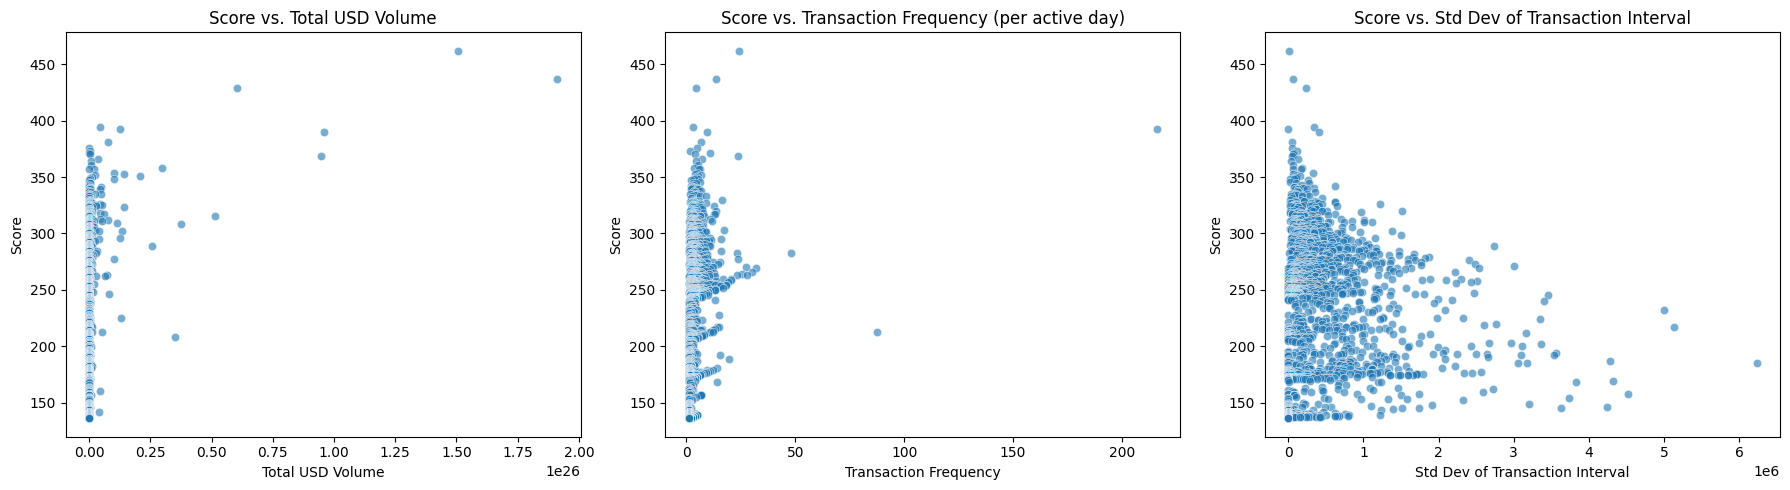

In [10]:
# 'full_scored_df' as above
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='total_usd_volume', y='score', data=full_scored_df, alpha=0.6)
plt.title('Score vs. Total USD Volume')
plt.xlabel('Total USD Volume')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
sns.scatterplot(x='txn_frequency_per_active_day', y='score', data=full_scored_df, alpha=0.6)
plt.title('Score vs. Transaction Frequency (per active day)')
plt.xlabel('Transaction Frequency')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
sns.scatterplot(x='std_txn_interval', y='score', data=full_scored_df, alpha=0.6)
plt.title('Score vs. Std Dev of Transaction Interval')
plt.xlabel('Std Dev of Transaction Interval')
plt.ylabel('Score')
plt.tight_layout()
plt.show()